In [664]:
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_auc_score

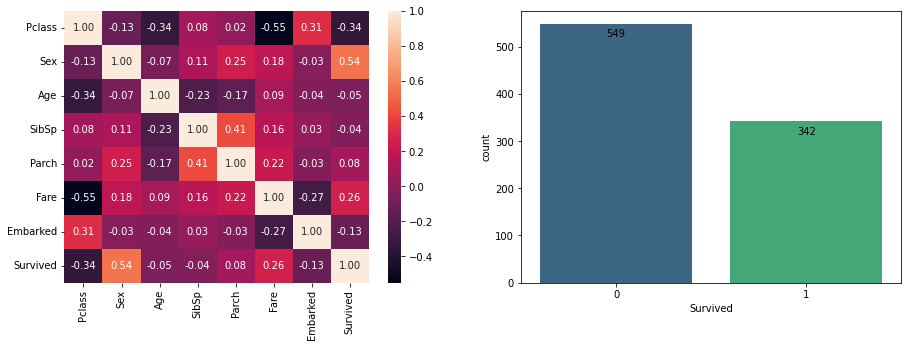

In [665]:
train_X = pd.read_csv('train_X.csv', sep=",")
train_y = pd.read_csv('train_Y.csv', sep=",")

train_X.drop('Id', axis=1, inplace=True)
train_y.drop('Id', axis=1, inplace=True)

df = train_X
df["Survived"] = train_y.values # Combining X and Y to get correlation map of all features.

fig, axes = plt.subplots(1,2, figsize=(15,5)) # Figure and axes

sns.heatmap(df.corr(), annot=True, fmt=".2f", ax = axes[0]) # Correlation Map

barplot = sns.countplot(x = "Survived", data = train_y, palette="viridis", ax = axes[1]) # Class Count Barplot
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
    ha = 'center', va = 'center', xytext = (0, -10), textcoords = 'offset points')

plt.show()

In [666]:
train_X = train_X.values.T # DataFrame to Transposed N-Dimensional Array
train_y = train_y.values.reshape(1, train_X.shape[1]) # DataFrame to reshaped N-Dimensional Array

print(train_X.shape)
print(train_y.shape)

(8, 891)
(1, 891)


In [667]:
class LogisticRegression:
    def __init__(self, X, y, learning_rate = 0.002, epochs = 1000):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.costs = list()  # Loss watch
        self.accuracies = list()  # Accuracy watch

    def sigmoid(self, x):
        return 1/(1 + math.e**(-x))
    
    def loss(self, m, y, A):
        cost = -(1/m) * np.sum(y * np.log(A) + (1-y) * np.log(1-A)) # Model Cost
        return cost

    def fit(self, verbose=False):
        m = self.X.shape[1] # Number of Observations
        n = self.X.shape[0] # Number of Features

        self.W = np.zeros((n, 1)) # Initial Weight Matrix
        self.B = 0 # Initial Interception Value

        for epoch in range(self.epochs): # Epochs
            Z = np.dot(self.W.T, self.X) + self.B
            A = self.sigmoid(Z) # Activation -> final value/probability

            dW = (1/m) * np.dot(A-self.y, self.X.T)
            dB = (1/m) * np.sum(A-self.y)

            self.W -= self.learning_rate * dW.T
            self.B -= self.learning_rate * dB

            cost = self.loss(m, self.y, A)
            self.costs.append(cost)
            
            train_acc = self.clf_accuracy(train_X, train_y)
            self.accuracies.append(train_acc)

            if verbose == True:
                print(f"Epoch: {epoch} -> Accuracy: {train_acc}, Loss: {cost}")
                
        return self.W, self.B, self.costs, self.accuracies
    
    def predict(self, x, probability = True):
        Z = np.dot(self.W.T, x) + self.B
        A = self.sigmoid(Z)

        if probability == True: return A[0]
        else: return np.array([1 if proba > 0.5 else 0 for proba in A[0]])
    
    def clf_accuracy(self, x, y):
        predictions = self.predict(x, False)
        y_and_yhat = list(zip(predictions, y[0]))

        correctly_predicted = [1 for i, j in y_and_yhat if i == j].count(1)
        return correctly_predicted/len(predictions)
    
    def metric_count(self, y, y_hat):
        TP, TN, FP, FN = 0, 0, 0, 0

        for yi, yi_hat in list(zip(y[0], y_hat)):
            if yi_hat > yi:
                FN += 1
            elif yi_hat < yi:
                FP += 1
            elif yi_hat == 1 and yi_hat == yi:
                TN += 1
            elif yi_hat == 0 and yi_hat == yi:
                TP += 1
        
        return TP, TN, FP, FN

    def evaluate(self, y = None, y_hat = None):
        if y == None and y_hat == None:
            y = self.y
            y_hat = self.predict(self.X, False)

        TP, TN, FP, FN = self.metric_count(y, y_hat)

        total_data = TP + FP + TN + FN
        TP_percentage = TP / total_data * 100
        FP_percentage = FP / total_data * 100
        TN_percentage = TN / total_data * 100
        FN_percentage = FN / total_data * 100
        print(f"True Positive Percentage: {TP_percentage:.2f}%\nFalse Positive Percentage: {FP_percentage:.2f}%\
            \nTrue Negative Percentage: {TN_percentage:.2f}%\nFalse Negative Percentage: {FN_percentage:.2f}%")
        
        conf_matrix = np.array([[TP, FN], [FP, TN]])
        sns.heatmap(conf_matrix, annot=True, fmt='d', linewidths=.3, cmap="YlGnBu")
        plt.show()
        
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        sensitivity = recall
        specificity = TN / (TN + FP)
        accuracy = (TP + TN) / (TP + FP + TN + FN) # Important when the dataset is balanced
        
        return precision, recall, f1_score, sensitivity, specificity, accuracy

    def pr_curve(self, y=None, y_hat=None, step_size = 1000):        
        if y == None and y_hat == None:
            y = self.y
            y_hat = self.predict(self.X, True)

        precision_watch, recall_watch = list(), list()
        precision_last, recall_last = list(), list()
        thresholds = np.linspace(0, 1, step_size)

        for th in thresholds:
            yhat_threshold = [1 if yi_hat > th else 0 for yi_hat in y_hat] # Outputs according to different thresholds.
            TP, _, FP, FN = self.metric_count(y, yhat_threshold) # TP, TN, FP and FN for each different output list.
            
            if (TP + FP == 0) or (TP + FN == 0):
                precision_watch.append(0)
                recall_watch.append(0)
            else:
                precision = TP / (TP + FP) # Precision
                recall = TP / (TP + FN) # Recall

                if precision > 0.5 and recall > 0.5:
                    precision_watch.append(precision)
                    recall_watch.append(recall)

        for i, j in zip(precision_watch, recall_watch):
            if i > 0.5:
                precision_last.append(i)
                recall_last.append(j)

        return precision_last, recall_last, thresholds

    def roc_curve(self, y=None, y_hat=None, step_size = 1000):
        if y == None and y_hat == None:
            y = self.y
            y_hat = self.predict(self.X, True)

        true_rates, false_rates = list(), list()
        thresholds = np.linspace(0, 1, step_size)

        for th in thresholds:
            yhat_threshold = [1 if yi_hat > th else 0 for yi_hat in y_hat] # Outputs according to different thresholds.
            TP, TN, FP, FN = self.metric_count(y, yhat_threshold) # TP, TN, FP and FN for each different output list.

            TPR = TP / (TP + FN) # True Positive Rate / Sensitivity / Recall
            FPR = FP / (FP + TN) # False Positive Rate / 1 - Specificity

            true_rates.append(1-TPR)
            false_rates.append(1-FPR)

        return true_rates, false_rates, thresholds

    def visualize(self):
        x_axis = np.arange(0, self.epochs)

        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(15, 5)
        fig.set_tight_layout(True)
        
        ax[0].plot(x_axis, self.costs)
        ax[0].set_title("Epoch-Loss Graphic")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")

        ax[1].plot(x_axis, self.accuracies)
        ax[1].set_title("Epoch-Accuracy Graphic")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Accuracy")
                
        plt.show()

In [668]:
logistic_reg = LogisticRegression(train_X, train_y, epochs=5000, learning_rate=0.001)

In [669]:
_,_,_,_ = logistic_reg.fit(verbose=False)

In [670]:
logistic_reg.visualize()

KeyboardInterrupt: 

In [ ]:
logistic_reg.clf_accuracy(train_X, train_y) # Training Accuracy

0.8911335578002245

In [ ]:
pred = logistic_reg.predict(train_X)

True Positive Percentage: 60.38%
False Positive Percentage: 9.65%            
True Negative Percentage: 28.73%
False Negative Percentage: 1.23%


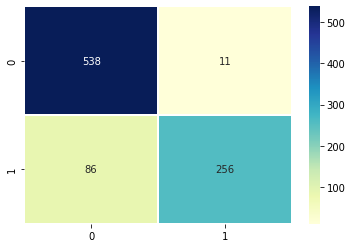

Precision:  0.8621794871794872
Recall:  0.9799635701275046
F1 Score:  0.9173060528559251
Sensitivity:  0.9799635701275046
Specificity:  0.7485380116959064
Accuracy:  0.8911335578002245


In [ ]:
precision, recall, f1_score, sensitivity, specificity, accuracy = logistic_reg.evaluate()

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)
print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)
print("Accuracy: ", accuracy)

AUC Score: 0.9801233502700285


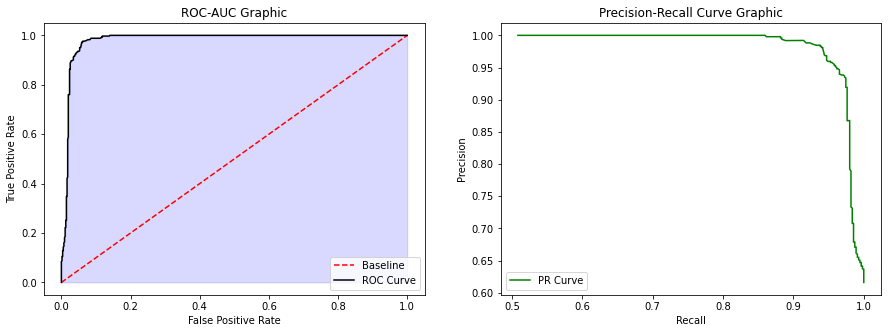

In [671]:
fig, axes = plt.subplots(1,2, figsize=(15,5)) # Figure and axes

fpr, tpr, _ = logistic_reg.roc_curve()
print(f"AUC Score: {roc_auc_score(train_y[0], pred)}") # AUC Score

axes[0].plot([0, 1], [0, 1], ls='--', label="Baseline", c="red")
axes[0].plot(fpr, tpr, label="ROC Curve", c="black")
axes[0].fill_between(fpr, tpr, color="blue", alpha=0.15)
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC-AUC Graphic")
axes[0].legend(loc=4)

precision, recall, _ = logistic_reg.pr_curve(step_size=1000)
axes[1].plot(recall, precision, label="PR Curve", c="green")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve Graphic")
axes[1].legend(loc=3)

plt.show()
